In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import ks_2samp
import scipy as st
import scipy.stats
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [3]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [4]:
population=pd.read_csv("population.csv")

In [5]:
print( str(population.isna().sum()) + '\n')
 

Code Domaine                0
Domaine                     0
Code zone (FAO)             0
Zone                        0
Code Élément                0
Élément                     0
Code Produit                0
Produit                     0
Code année                  0
Année                       0
Unité                       0
Valeur                      0
Symbole                     0
Description du Symbole      0
Note                      451
dtype: int64



In [6]:
df=pd.pivot_table(population, values="Valeur", index=['Code zone (FAO)','Zone'], columns='Année',aggfunc=sum).reset_index()

In [7]:
df

Année,Code zone (FAO),Zone,2014,2015
0,1,Arménie,2912.409,2925.553
1,2,Afghanistan,33370.794,34413.603
2,3,Albanie,2896.305,2890.513
3,4,Algérie,38923.692,39728.025
4,5,Samoa américaines,55.791,55.812
...,...,...,...,...
232,280,Sint Maarten (partie néerlandaise),38.876,39.968
233,281,Saint-Martin (partie française),36.015,35.858
234,282,Saint-Barthélemy,9.623,9.693
235,299,Palestine,4428.639,4529.166


In [8]:
df['pop_diff']=df[2015]-df[2014]

In [9]:
df['pop_ratio']=(df['pop_diff']/df[2014])*100

In [10]:
df_pop=df[['Zone','pop_ratio']].copy()
df_pop.head()

Année,Zone,pop_ratio
0,Arménie,0.451310
1,Afghanistan,3.124915
2,Albanie,-0.199979
3,Algérie,2.066436
4,Samoa américaines,0.037640


In [11]:
vege=pd.read_csv('vegetaux.csv')
anim=pd.read_csv('animal.csv')

In [12]:
vege['origine'] = 'vegetale'
anim['origine'] = 'animal'

In [13]:
print(str(anim.isna().sum()) + '\n' )
print(str(vege.isna().sum()) + '\n')

Code Domaine              0
Domaine                   0
Code zone (FAO)           0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
origine                   0
dtype: int64

Code Domaine              0
Domaine                   0
Code zone (FAO)           0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
origine                   0
dtype: int64



In [14]:
animal_vegetal = pd.concat([anim, vege])
animal_vegetal.head()

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,origine
0,FBS,Bilans Alimentaires (2014-),2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2941,Produits Animaux,2014,2014,Kcal/personne/jour,206.00,Fc,Donnée calculée,animal
1,FBS,Bilans Alimentaires (2014-),2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2941,Produits Animaux,2014,2014,g/personne/jour,12.11,Fc,Donnée calculée,animal
2,FBS,Bilans Alimentaires (2014-),2,Afghanistan,684,Disponibilité de matière grasse en quantité (g...,2941,Produits Animaux,2014,2014,g/personne/jour,14.36,Fc,Donnée calculée,animal
3,FBS,Bilans Alimentaires (2014-),2,Afghanistan,5511,Production,2731,Viande de Bovins,2014,2014,Milliers de tonnes,137.00,Im,Données de la FAO basées sur une méthodologie ...,animal
4,FBS,Bilans Alimentaires (2014-),2,Afghanistan,5611,Importations - Quantité,2731,Viande de Bovins,2014,2014,Milliers de tonnes,16.00,Im,Données de la FAO basées sur une méthodologie ...,animal


In [15]:
animal_vegetal.isnull().sum()

Code Domaine              0
Domaine                   0
Code zone (FAO)           0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
origine                   0
dtype: int64

In [16]:
animal_vegetal=pd.pivot_table(animal_vegetal,columns='Élément', index=['Code zone (FAO)', 'Zone', 'Code Produit', 'Produit','origine'],values='Valeur',aggfunc=np.sum).reset_index()

In [17]:
animal_vegetal.head()

Élément,Code zone (FAO),Zone,Code Produit,Produit,origine,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Semences,Variation de stock
0,1,Arménie,2511,Blé et produits,vegetale,110.0,0.0,1107.0,139.33,3.90,33.01,639.0,1.0,344.0,406.0,30.0,338.0,32.0,42.0
1,1,Arménie,2513,Orge et produits,vegetale,152.0,5.0,8.0,0.97,0.04,0.28,196.0,0.0,6.0,3.0,16.0,190.0,15.0,0.0
2,1,Arménie,2514,Maïs et produits,vegetale,33.0,NaN,0.0,0.01,0.00,0.00,39.0,NaN,52.0,0.0,7.0,20.0,0.0,33.0
3,1,Arménie,2515,Seigle et produits,vegetale,0.0,NaN,1.0,0.13,0.01,0.03,0.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0
4,1,Arménie,2516,Avoine,vegetale,6.0,NaN,5.0,0.47,0.09,0.19,8.0,NaN,1.0,1.0,0.0,7.0,1.0,-1.0


In [18]:
animal_vegetal = animal_vegetal.rename(columns = {'Disponibilité intérieure' : 'dispo_int', 
                                          'Disponibilité alimentaire (Kcal/personne/jour)' : 'dispo_kcal_j',
                                          'Disponibilité alimentaire en quantité (kg/personne/an)' : 'dispo_kg_p',
                                          'Disponibilité de matière grasse en quantité (g/personne/jour)' : 'dispo_mat_g_p_j',
                                          'Disponibilité de protéines en quantité (g/personne/jour)' : 'dispo_prot_g_p_j'})

In [19]:
animal_vegetal = pd.pivot_table(animal_vegetal, index=['Code zone (FAO)', 'Zone'], columns='origine', values=['dispo_prot_g_p_j', 'dispo_kcal_j'], aggfunc=np.sum).reset_index()
columns = animal_vegetal.columns
new_index = pd.Index([e[0] + e[1] for e in columns.tolist()])
animal_vegetal.columns = new_index



In [20]:
animal_vegetal

,Code zone (FAO),Zone,dispo_kcal_janimal,dispo_kcal_jvegetale,dispo_prot_g_p_janimal,dispo_prot_g_p_jvegetale
0,1,Arménie,1622.0,4512.0,90.75,104.27
1,2,Afghanistan,412.0,3779.0,24.23,92.12
2,3,Albanie,1874.0,4654.0,112.40,106.70
3,4,Algérie,888.0,5860.0,55.49,134.27
4,7,Angola,550.0,4283.0,44.55,71.28
...,...,...,...,...,...,...
171,256,Luxembourg,2268.0,4720.0,137.54,85.61
172,272,Serbie,1554.0,4056.0,87.28,83.59
173,273,Monténégro,2369.0,4381.0,128.76,85.53
174,276,Soudan,758.0,4416.0,43.12,105.16


In [21]:
animal_vegetal.isnull().sum()

Code zone (FAO)             0
Zone                        0
dispo_kcal_janimal          0
dispo_kcal_jvegetale        2
dispo_prot_g_p_janimal      0
dispo_prot_g_p_jvegetale    2
dtype: int64

In [22]:
animal_vegetal[animal_vegetal['dispo_kcal_jvegetale'].isnull()]


,Code zone (FAO),Zone,dispo_kcal_janimal,dispo_kcal_jvegetale,dispo_prot_g_p_janimal,dispo_prot_g_p_jvegetale
28,45,Comores,0.0,NaN,0.0,NaN
136,196,Seychelles,0.0,NaN,0.0,NaN


In [23]:
animal_vegetal=animal_vegetal.drop(index=[28,136])

In [24]:
animal_vegetal.isnull().sum()

Code zone (FAO)             0
Zone                        0
dispo_kcal_janimal          0
dispo_kcal_jvegetale        0
dispo_prot_g_p_janimal      0
dispo_prot_g_p_jvegetale    0
dtype: int64

In [25]:
animal_vegetal['%prot_anim_prot_tot'] = round((animal_vegetal['dispo_prot_g_p_janimal']/(animal_vegetal['dispo_prot_g_p_janimal'] + animal_vegetal['dispo_prot_g_p_jvegetale']))*100, 2)
animal_vegetal.head()

,Code zone (FAO),Zone,dispo_kcal_janimal,dispo_kcal_jvegetale,dispo_prot_g_p_janimal,dispo_prot_g_p_jvegetale,%prot_anim_prot_tot
0,1,Arménie,1622.0,4512.0,90.75,104.27,46.53
1,2,Afghanistan,412.0,3779.0,24.23,92.12,20.83
2,3,Albanie,1874.0,4654.0,112.40,106.70,51.30
3,4,Algérie,888.0,5860.0,55.49,134.27,29.24
4,7,Angola,550.0,4283.0,44.55,71.28,38.46


In [26]:
animal_vegetal.isnull().sum()

Code zone (FAO)             0
Zone                        0
dispo_kcal_janimal          0
dispo_kcal_jvegetale        0
dispo_prot_g_p_janimal      0
dispo_prot_g_p_jvegetale    0
%prot_anim_prot_tot         0
dtype: int64

In [27]:
#dispo prot par habitant par habitant par ans

animal_vegetal['dispo_prot_hab_ans'] = (animal_vegetal['dispo_prot_g_p_janimal'] + animal_vegetal['dispo_prot_g_p_jvegetale']) * 365

In [28]:
#dispo KCLA par habitant par habitant par ans
animal_vegetal['dispo_kcal_hab_ans'] = (animal_vegetal['dispo_kcal_janimal'] + animal_vegetal['dispo_kcal_jvegetale']) * 365

In [29]:
animal_vegetal.head()

,Code zone (FAO),Zone,dispo_kcal_janimal,dispo_kcal_jvegetale,dispo_prot_g_p_janimal,dispo_prot_g_p_jvegetale,%prot_anim_prot_tot,dispo_prot_hab_ans,dispo_kcal_hab_ans
0,1,Arménie,1622.0,4512.0,90.75,104.27,46.53,71182.30,2238910.0
1,2,Afghanistan,412.0,3779.0,24.23,92.12,20.83,42467.75,1529715.0
2,3,Albanie,1874.0,4654.0,112.40,106.70,51.30,79971.50,2382720.0
3,4,Algérie,888.0,5860.0,55.49,134.27,29.24,69262.40,2463020.0
4,7,Angola,550.0,4283.0,44.55,71.28,38.46,42277.95,1764045.0


In [30]:
#jointure entre la population et le dtaframe df1 
df3=pd.merge(animal_vegetal,df_pop, on=['Zone'])
df3

,Code zone (FAO),Zone,dispo_kcal_janimal,dispo_kcal_jvegetale,dispo_prot_g_p_janimal,dispo_prot_g_p_jvegetale,%prot_anim_prot_tot,dispo_prot_hab_ans,dispo_kcal_hab_ans,pop_ratio
0,1,Arménie,1622.0,4512.0,90.75,104.27,46.53,71182.30,2238910.0,0.451310
1,2,Afghanistan,412.0,3779.0,24.23,92.12,20.83,42467.75,1529715.0,3.124915
2,3,Albanie,1874.0,4654.0,112.40,106.70,51.30,79971.50,2382720.0,-0.199979
3,4,Algérie,888.0,5860.0,55.49,134.27,29.24,69262.40,2463020.0,2.066436
4,7,Angola,550.0,4283.0,44.55,71.28,38.46,42277.95,1764045.0,3.498663
...,...,...,...,...,...,...,...,...,...,...
169,256,Luxembourg,2268.0,4720.0,137.54,85.61,61.64,81449.75,2550620.0,2.204625
170,272,Serbie,1554.0,4056.0,87.28,83.59,51.08,62367.55,2047650.0,-0.241754
171,273,Monténégro,2369.0,4381.0,128.76,85.53,60.09,78215.85,2463750.0,0.049629
172,276,Soudan,758.0,4416.0,43.12,105.16,29.08,54122.20,1888510.0,2.436420


In [31]:
# On supprime les dataframes population et bilan_alim pour éviter d'avoir des doublons
del animal_vegetal
del population

In [32]:
ks_2samp(df3["dispo_kcal_hab_ans"],list(np.random.normal(np.mean(df3["dispo_kcal_hab_ans"]), np.std(df3["dispo_kcal_hab_ans"]), 1000)))

KstestResult(statistic=0.0790919540229885, pvalue=0.29425328682332363)

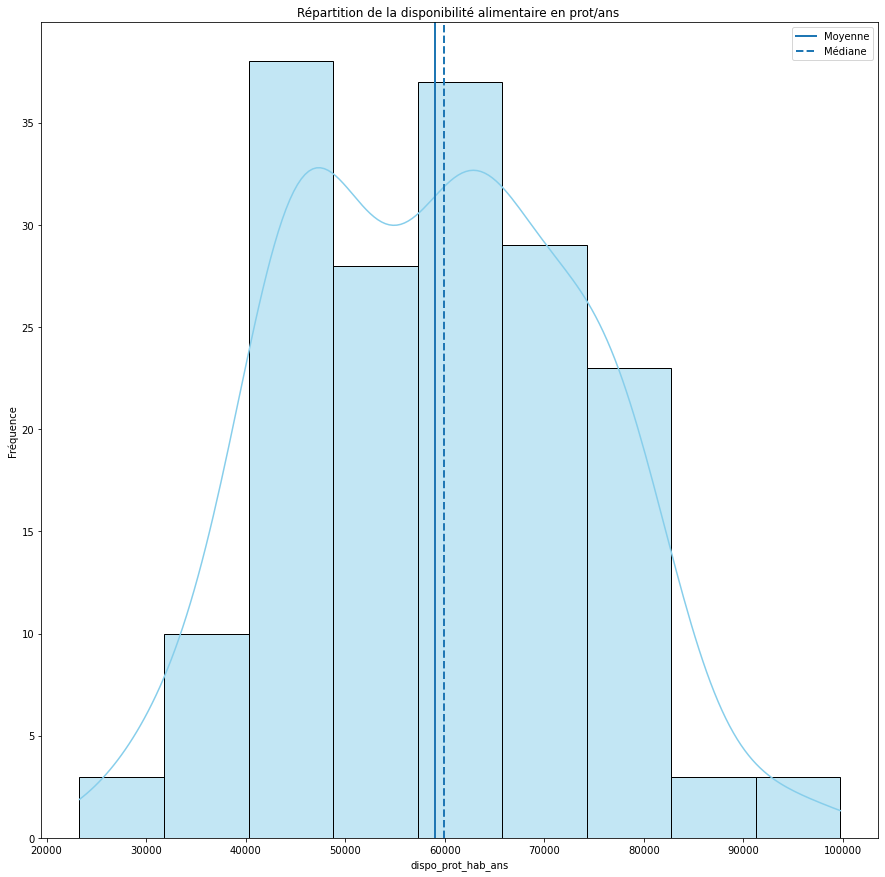

In [33]:
#Test de loi normal

plt.figure(figsize = (15,15))

sns.histplot(df3["dispo_prot_hab_ans"],
                  kde=True,
                  color='skyblue',
                  )
plt.axvline(x=df3['dispo_prot_hab_ans'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df3['dispo_prot_hab_ans'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('dispo_prot_hab_ans')
plt.ylabel('Fréquence')
plt.title('Répartition de la disponibilité alimentaire en prot/ans ')
plt.legend()
plt.show()

In [34]:
ks_2samp(df3["dispo_prot_hab_ans"],list(np.random.normal(np.mean(df3["dispo_prot_hab_ans"]), np.std(df3["dispo_prot_hab_ans"]), 1000)))

KstestResult(statistic=0.06262068965517241, pvalue=0.5813189182645813)

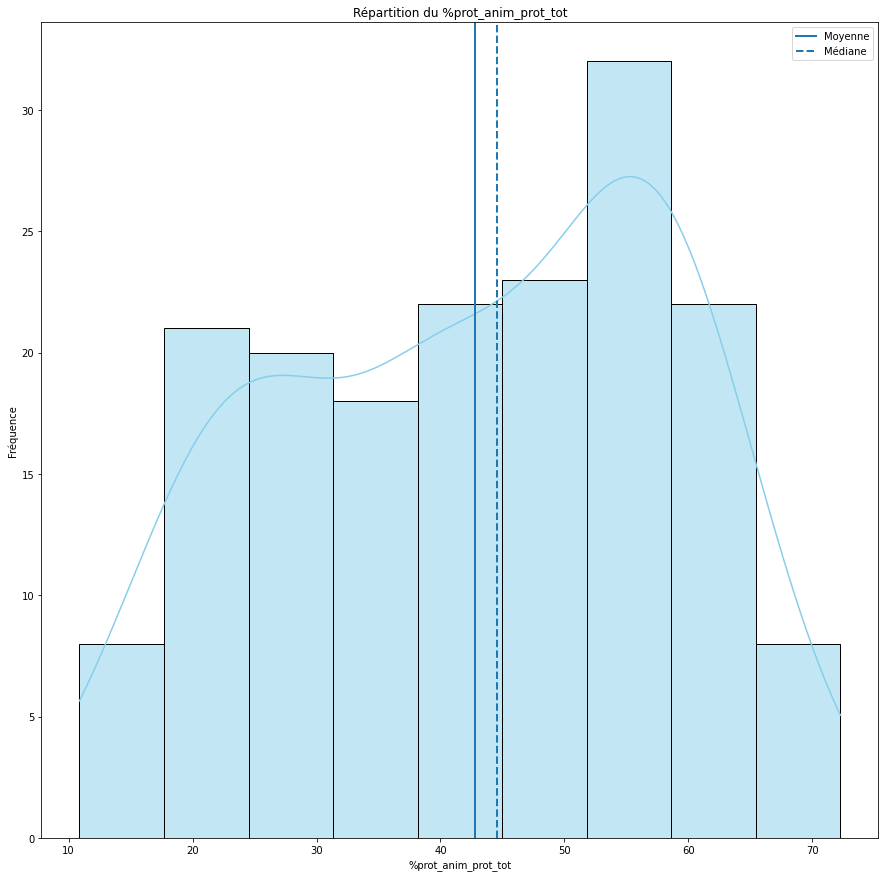

In [35]:
#Test de loi normal

plt.figure(figsize = (15,15))

sns.histplot(df3["%prot_anim_prot_tot"],
                  kde=True,
                  color='skyblue',
                  )
plt.axvline(x=df3['%prot_anim_prot_tot'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df3['%prot_anim_prot_tot'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('%prot_anim_prot_tot')
plt.ylabel('Fréquence')
plt.title('Répartition du %prot_anim_prot_tot')
plt.legend()
plt.show()

In [36]:
ks_2samp(df3["%prot_anim_prot_tot"],list(np.random.normal(np.mean(df3["%prot_anim_prot_tot"]), np.std(df3["%prot_anim_prot_tot"]), 1000)))

KstestResult(statistic=0.08685057471264368, pvalue=0.20004596103829997)

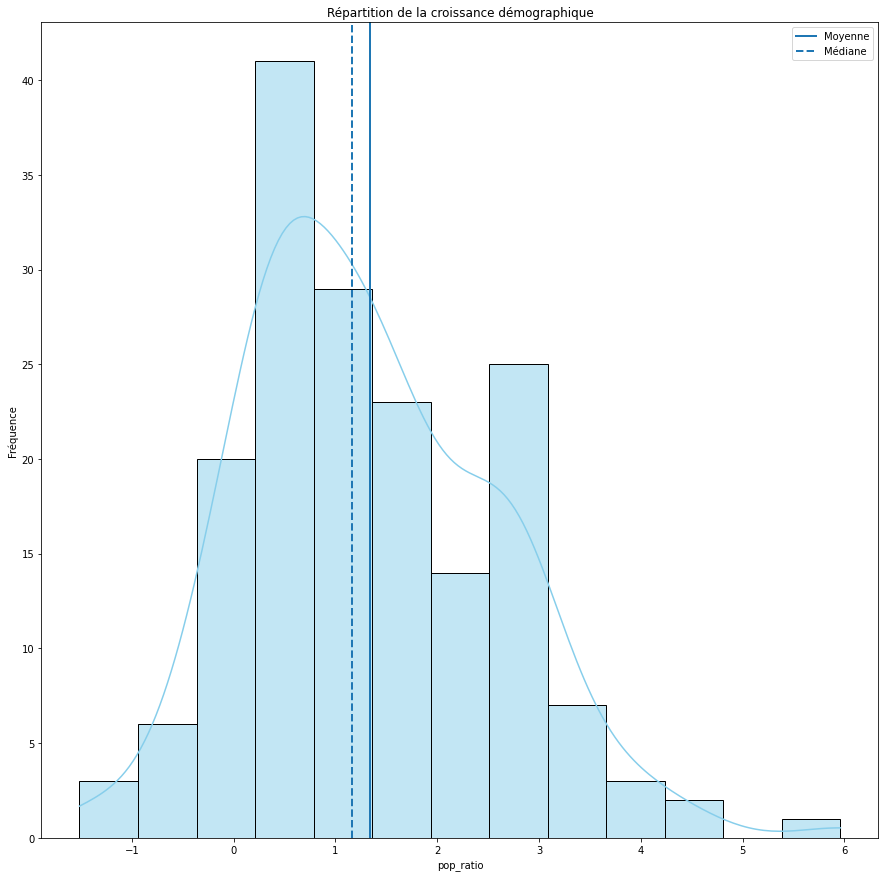

In [37]:
#Test de loi normal

plt.figure(figsize = (15,15))

sns.histplot(df3["pop_ratio"],
                  kde=True,
                  color='skyblue',
                  )
plt.axvline(x=df3['pop_ratio'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df3['pop_ratio'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('pop_ratio')
plt.ylabel('Fréquence')
plt.title('Répartition de la croissance démographique')
plt.legend()
plt.show()

In [38]:
ks_2samp(df3["pop_ratio"],list(np.random.normal(np.mean(df3["pop_ratio"]), np.std(df3["pop_ratio"]), 1000)))

KstestResult(statistic=0.06855172413793104, pvalue=0.46609214070122607)

In [39]:
df5=df3[['Zone','%prot_anim_prot_tot','dispo_prot_hab_ans','dispo_kcal_hab_ans','pop_ratio']]

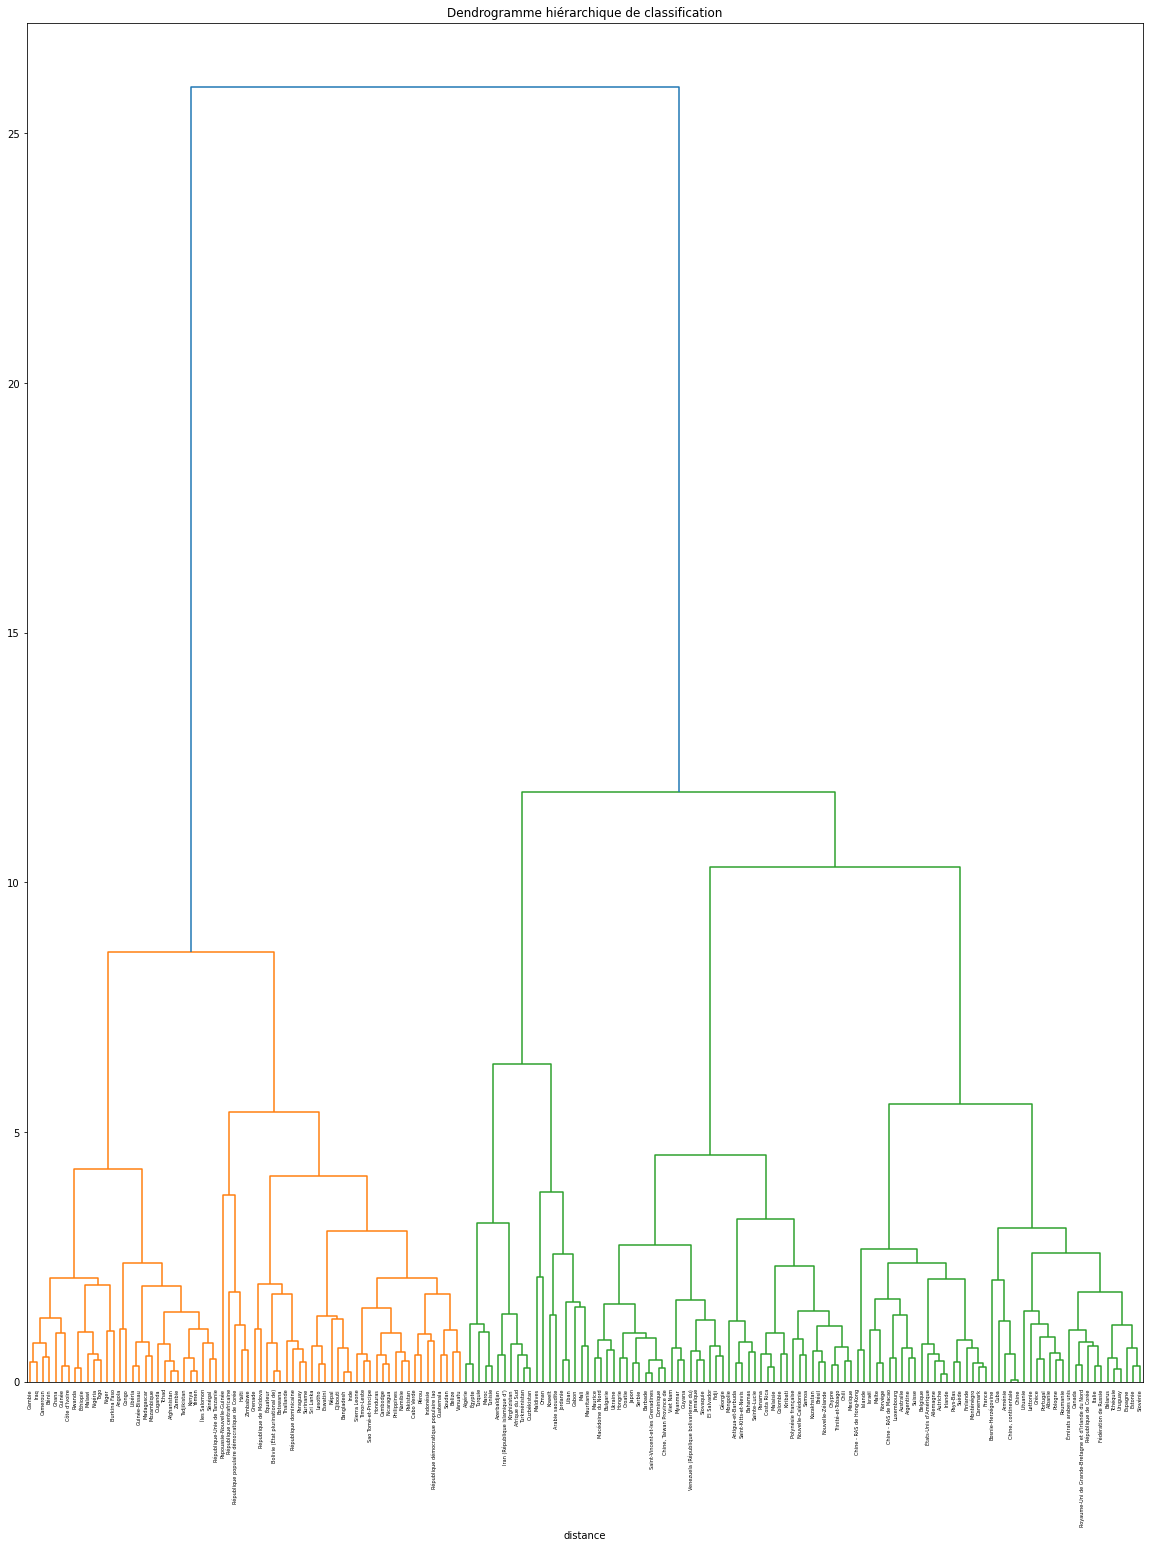

In [40]:
#classification hierarchique

#Transformation en array Numpy
#Indexation selon les pays par la fonction .set_index()
df5.set_index('Zone', inplace=True)
X = df5.values


# préparation des données pour le clustering
X = df5.values
names = df5.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(20,25))
dendrogram(Z,
        labels = names,
        orientation = "top")
plt.title('Dendrogramme hiérarchique de classification')
plt.xlabel('distance')


plt.show()



In [41]:
#Coupage du dendrogramme en 5 clusters
#fig = plt.figure(figsize=(30,10))
#plt.title('Hierarchical Clustering Dendrogram - 5 clusters', fontsize=20)
#plt.xlabel('distance', fontsize=15)

#dendrogram(Z, labels = df5.index, p=5, truncate_mode='lastp', orientation='right')
#plt.show()

In [42]:
# On récupère les données du dendrogramme
# puis on crée un DataFrame avec la liste des pays associée à leur cluster

cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster = pd.DataFrame({'Zone' : df5.index.tolist(),
                             'Pays_cluster' : cluster})
data_cluster = data_cluster.sort_values(['Pays_cluster', 'Zone'])
data_cluster.to_csv('P5_03_listespays.csv')

In [43]:
data_cluster

,Zone,Pays_cluster
1,Afghanistan,1
4,Angola,1
159,Burkina Faso,1
33,Bénin,1
19,Cameroun,1
...,...,...
143,Suède,5
116,Tchéquie,5
160,Uruguay,5
154,Émirats arabes unis,5


In [44]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 4
data_pca = df5[['dispo_kcal_hab_ans','dispo_prot_hab_ans','%prot_anim_prot_tot','pop_ratio']]

X = df5.values
names = df5.index
features = df5.columns

In [45]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [46]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

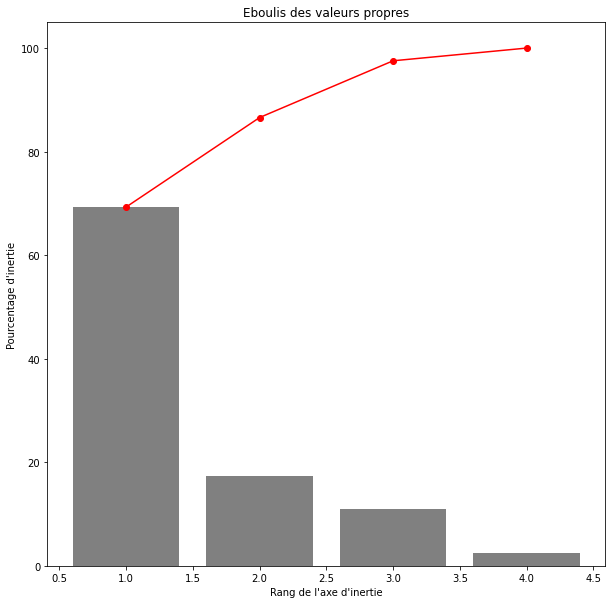

In [47]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

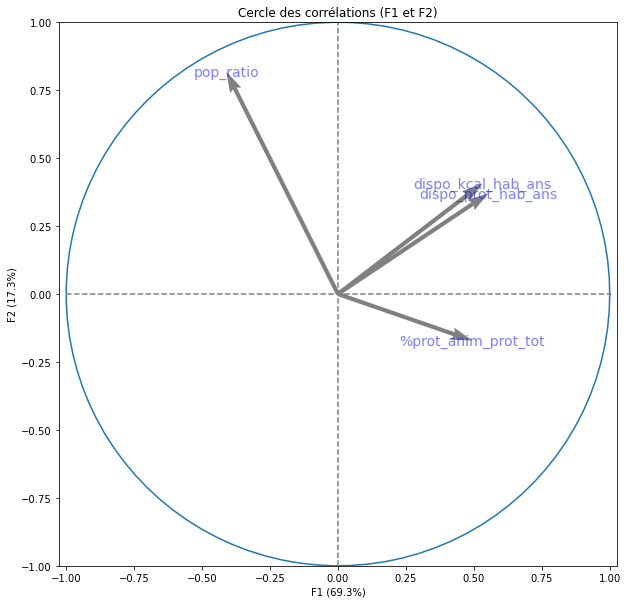

In [48]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))



In [49]:
df5=pd.merge(df5,data_cluster, on='Zone')
Pays=df5["Pays_cluster"]

In [50]:
df5

,Zone,%prot_anim_prot_tot,dispo_prot_hab_ans,dispo_kcal_hab_ans,pop_ratio,Pays_cluster
0,Arménie,46.53,71182.30,2238910.0,0.451310,5
1,Afghanistan,20.83,42467.75,1529715.0,3.124915,1
2,Albanie,51.30,79971.50,2382720.0,-0.199979,5
3,Algérie,29.24,69262.40,2463020.0,2.066436,3
4,Angola,38.46,42277.95,1764045.0,3.498663,1
...,...,...,...,...,...,...
169,Luxembourg,61.64,81449.75,2550620.0,2.204625,5
170,Serbie,51.08,62367.55,2047650.0,-0.241754,4
171,Monténégro,60.09,78215.85,2463750.0,0.049629,5
172,Soudan,29.08,54122.20,1888510.0,2.436420,2


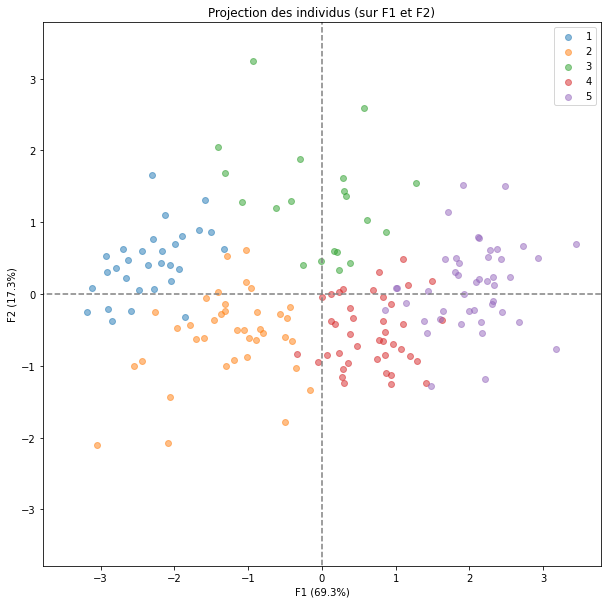

In [51]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = Pays , alpha = 0.5)

plt.show()
plt.show()

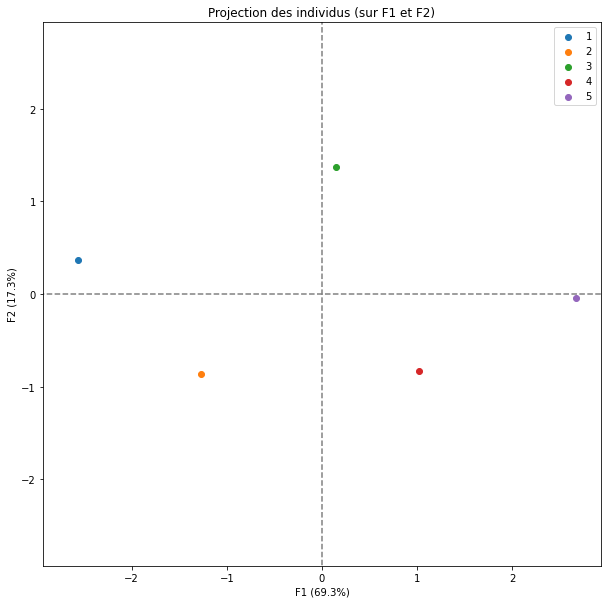

In [52]:
#Projection des centroides des clusters sur nos 2 composantes


df_centro = df5.groupby('Pays_cluster').mean()

X = df_centro.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df_centro.index)

In [53]:
df5['Pays_cluster'].value_counts()

5    45
4    41
2    38
1    30
3    20
Name: Pays_cluster, dtype: int64

In [54]:
# la position des centroïdes
c_centroid = pd.DataFrame(X_scaled, columns=df_centro.columns, index=df_centro.index)
c_centroid.to_csv('P5_04_coordonneescentroide.csv')

In [55]:
#Comparaison des clusters par moyennes selon les differents critères

df_com = pd.pivot_table(df5, columns='Pays_cluster', aggfunc=np.mean).transpose()
df_com= df_com[['dispo_prot_hab_ans','dispo_kcal_hab_ans','%prot_anim_prot_tot','pop_ratio']]
df_com

,dispo_prot_hab_ans,dispo_kcal_hab_ans,%prot_anim_prot_tot,pop_ratio
Pays_cluster,,,,
1,43187.043333,1.731122e+06,21.695667,2.861073
2,45132.826316,1.782189e+06,34.947368,1.391496
3,65988.715000,2.241556e+06,37.986000,2.626569
4,60682.852439,2.095367e+06,52.623171,0.589999
5,76869.324444,2.454901e+06,56.667333,0.381290


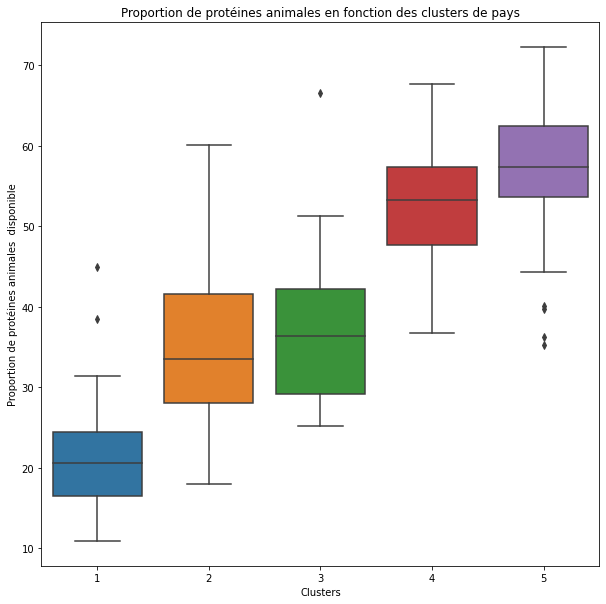

In [56]:
plt.figure(figsize=(10,10))

sns.boxplot(x='Pays_cluster', y='%prot_anim_prot_tot', data=df5)
plt.xlabel('Clusters')
plt.ylabel('Proportion de protéines animales  disponible')
plt.title('Proportion de protéines animales en fonction des clusters de pays')


plt.show()

In [57]:
#Hypothese a verifier pour l"gélaiter des variance entre  les deux clusters pour la proteine
#Les medianes sont different je vais le confirmer avec le test des comparaison des distributions

In [58]:
#Estce aue les variances sont egales
cluster1 = df5[df5["Pays_cluster"]==1]["%prot_anim_prot_tot"]
cluster2 = df5[df5["Pays_cluster"]==2]["%prot_anim_prot_tot"]
st.stats.bartlett(cluster1,cluster2)

BartlettResult(statistic=4.205810682782795, pvalue=0.040285713979390694)

In [59]:
#Test egalité des moyennes 
st.stats.ttest_ind(cluster1,cluster2, equal_var=False)

Ttest_indResult(statistic=-6.075580359500585, pvalue=7.196863142898534e-08)

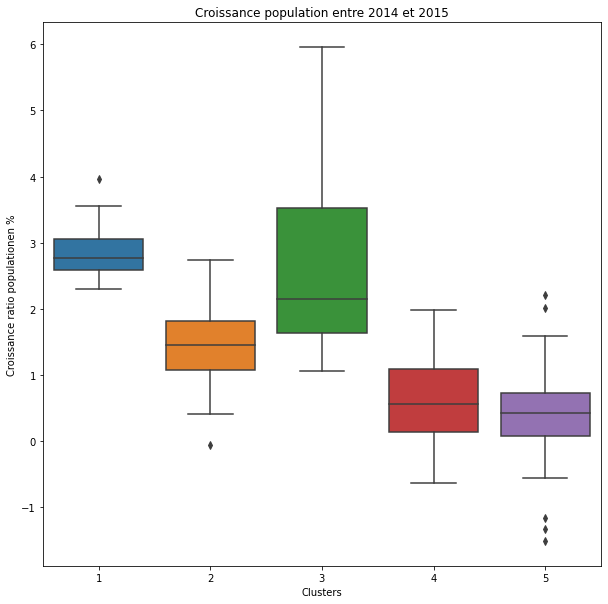

In [60]:
plt.figure(figsize=(10,10))

sns.boxplot(x='Pays_cluster', y='pop_ratio', data=df5)
plt.xlabel('Clusters')
plt.ylabel('Croissance ratio populationen %')
plt.title('Croissance population entre 2014 et 2015')


plt.show()

In [61]:
#Hypothese a verifier pour legalité des variance entre  les deux clusters pour la croissance de la population


In [62]:

clust1 = df5[df5["Pays_cluster"]==1]["pop_ratio"]
clust2 = df5[df5["Pays_cluster"]==2]["pop_ratio"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=7.535405990442924, pvalue=0.006049810314901918)

In [63]:
st.stats.ttest_ind(clust1,clust2, equal_var=False)

Ttest_indResult(statistic=11.991343339919343, pvalue=8.122470670224452e-18)

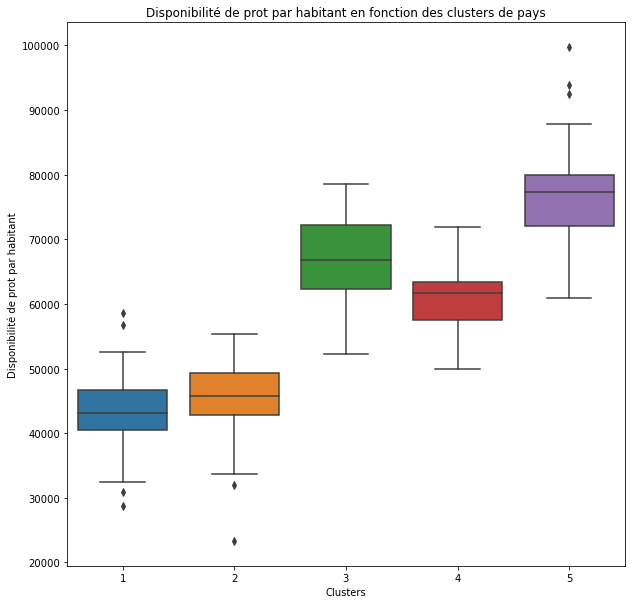

In [64]:
plt.figure(figsize=(10,10))

sns.boxplot(x='Pays_cluster', y='dispo_prot_hab_ans', data=df5)
plt.xlabel('Clusters')
plt.ylabel('Disponibilité de prot par habitant')
plt.title('Disponibilité de prot par habitant en fonction des clusters de pays')
plt.show()

In [65]:
cluster1 = df5[df5["Pays_cluster"]==1]["dispo_prot_hab_ans"]
cluster2 = df5[df5["Pays_cluster"]==2]["dispo_prot_hab_ans"]
st.stats.bartlett(cluster1,cluster2)

BartlettResult(statistic=0.03885286226204333, pvalue=0.8437404453987118)

In [66]:
#Test de student
st.stats.ttest_ind(cluster1,cluster2, equal_var=True)

Ttest_indResult(statistic=-1.2051343719720196, pvalue=0.2324547510271783)

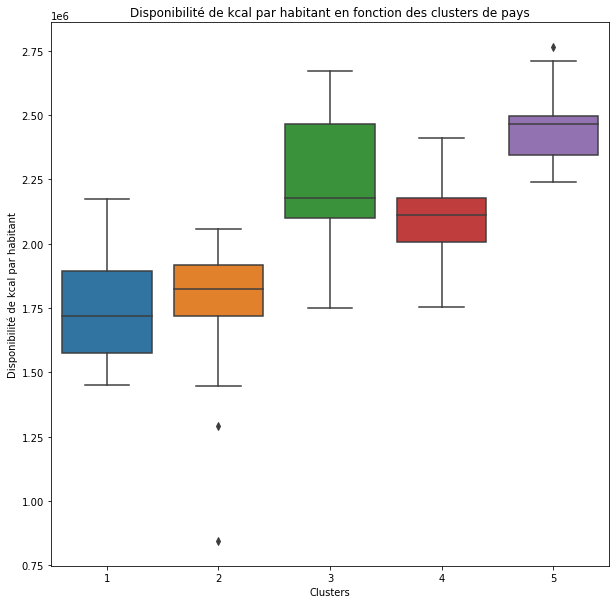

In [67]:
plt.figure(figsize=(10,10))

sns.boxplot(x='Pays_cluster', y='dispo_kcal_hab_ans', data=df5)
plt.xlabel('Clusters')
plt.ylabel('Disponibilité de kcal par habitant')
plt.title('Disponibilité de kcal par habitant en fonction des clusters de pays')
plt.show()

In [68]:
#Estce aue les variances sont egales
cluster1 = df5[df5["Pays_cluster"]==1]["dispo_kcal_hab_ans"]
cluster2 = df5[df5["Pays_cluster"]==2]["dispo_kcal_hab_ans"]
st.stats.bartlett(cluster1,cluster2)

BartlettResult(statistic=1.4211057170626133, pvalue=0.2332214932034723)

In [69]:
#Test de student
st.stats.ttest_ind(cluster1,cluster2, equal_var=True)

Ttest_indResult(statistic=-0.9852227884955382, pvalue=0.3281127241087983)

In [70]:
cluster15 = df5.loc[(df5['Pays_cluster']==1) | (df5['Pays_cluster']==2) |(df5['Pays_cluster']==3) |(df5['Pays_cluster']==4)]
cluster15.head()

,Zone,%prot_anim_prot_tot,dispo_prot_hab_ans,dispo_kcal_hab_ans,pop_ratio,Pays_cluster
1,Afghanistan,20.83,42467.75,1529715.0,3.124915,1
3,Algérie,29.24,69262.40,2463020.0,2.066436,3
4,Angola,38.46,42277.95,1764045.0,3.498663,1
5,Antigua-et-Barbuda,64.34,58294.15,1753095.0,1.084678,4
9,Bahamas,67.70,61758.00,1925375.0,0.964026,4


In [71]:
pib=pd.read_csv("pib.csv")
pib

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,2,Afghanistan,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,2102.4,X,Sources internationales sûres,NaN
1,FS,Données de la sécurité alimentaire,202,Afrique du Sud,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,12884.5,X,Sources internationales sûres,NaN
2,FS,Données de la sécurité alimentaire,3,Albanie,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,11586.9,X,Sources internationales sûres,NaN
3,FS,Données de la sécurité alimentaire,4,Algérie,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,11512.7,X,Sources internationales sûres,NaN
4,FS,Données de la sécurité alimentaire,79,Allemagne,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,50770.6,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,FS,Données de la sécurité alimentaire,234,Uruguay,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,22419.0,X,Sources internationales sûres,NaN
183,FS,Données de la sécurité alimentaire,155,Vanuatu,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,2984.6,X,Sources internationales sûres,NaN
184,FS,Données de la sécurité alimentaire,237,Viet Nam,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,6098.5,X,Sources internationales sûres,NaN
185,FS,Données de la sécurité alimentaire,251,Zambie,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2014,2014,I$,3450.0,X,Sources internationales sûres,NaN


In [72]:
pib.rename(columns={'Valeur':'PIB/habitant/US$'},inplace=True)

In [73]:
pib=pib[['Zone','PIB/habitant/US$']].copy()
pib.head()

,Zone,PIB/habitant/US$
0,Afghanistan,2102.4
1,Afrique du Sud,12884.5
2,Albanie,11586.9
3,Algérie,11512.7
4,Allemagne,50770.6


In [74]:
df6=pd.merge(cluster15,pib, on='Zone')

In [75]:
df6

,Zone,%prot_anim_prot_tot,dispo_prot_hab_ans,dispo_kcal_hab_ans,pop_ratio,Pays_cluster,PIB/habitant/US$
0,Afghanistan,20.83,42467.75,1529715.0,3.124915,1,2102.4
1,Algérie,29.24,69262.40,2463020.0,2.066436,3,11512.7
2,Angola,38.46,42277.95,1764045.0,3.498663,1,8239.8
3,Antigua-et-Barbuda,64.34,58294.15,1753095.0,1.084678,4,18104.4
4,Bahamas,67.70,61758.00,1925375.0,0.964026,4,35659.9
...,...,...,...,...,...,...,...
118,Éthiopie,11.72,46720.00,1641770.0,2.794448,1,1656.6
119,Samoa,60.49,63371.30,2170290.0,0.672143,4,5785.5
120,Zambie,19.24,43139.35,1468030.0,3.114153,1,3450.0
121,Serbie,51.08,62367.55,2047650.0,-0.241754,4,15226.3


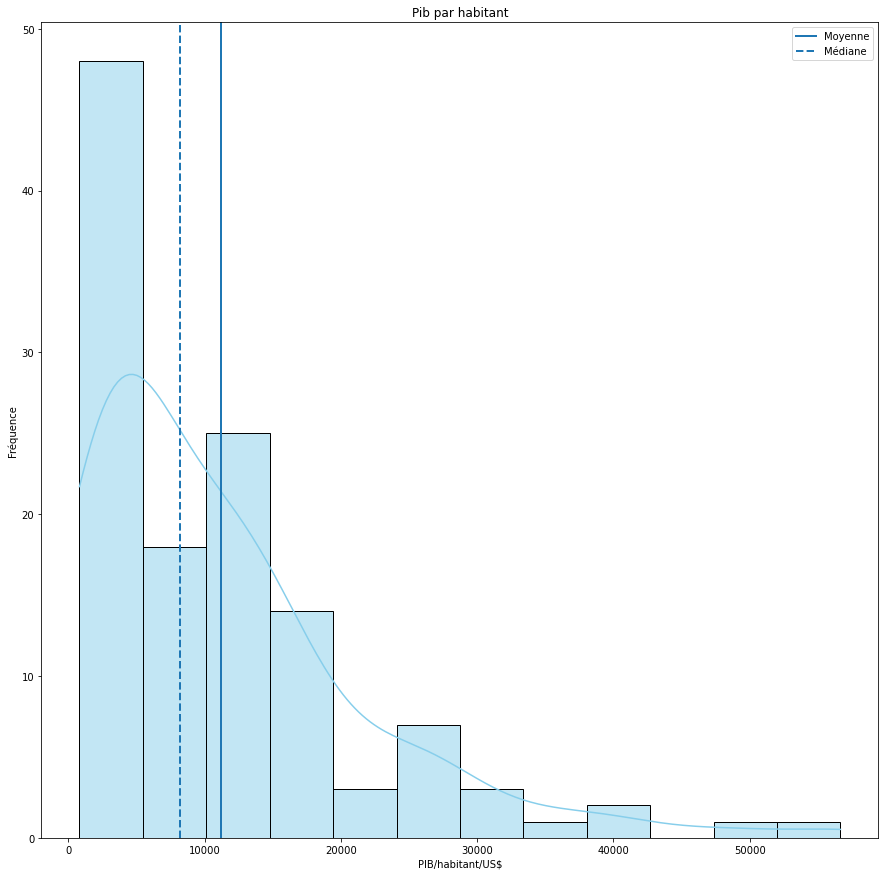

In [76]:
#Test de loi normal

plt.figure(figsize = (15,15))

sns.histplot(df6["PIB/habitant/US$"],
                  kde=True,
                  color='skyblue',
                  )
plt.axvline(x=df6['PIB/habitant/US$'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df6['PIB/habitant/US$'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('PIB/habitant/US$')
plt.ylabel('Fréquence')
plt.title('Pib par habitant')
plt.legend()
plt.show()

In [77]:
ks_2samp(df6["PIB/habitant/US$"],list(np.random.normal(np.mean(df6["PIB/habitant/US$"]), np.std(df6["PIB/habitant/US$"]), 1000)))

KstestResult(statistic=0.155, pvalue=0.009107149056921449)

In [78]:
#PIB Ne suis pas la loi normal

In [79]:
volail=pd.read_csv("volaile.csv")
volail

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit (CPC),Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,SCL,Compte Disponibilités et Utilisations (CDU),2,Afghanistan,5610,Importations - Quantité,21122.0,"Viande, canard",2014,2014,tonnes,129,*,Chiffre non officiel
1,SCL,Compte Disponibilités et Utilisations (CDU),2,Afghanistan,5141,Disponibilité alimentaire en quantité (tonnes),21122.0,"Viande, canard",2014,2014,tonnes,129,F,Estimation FAO
2,SCL,Compte Disponibilités et Utilisations (CDU),2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),21122.0,"Viande, canard",2014,2014,Kcal/personne/jour,0,Fc,Donnée calculée
3,SCL,Compte Disponibilités et Utilisations (CDU),2,Afghanistan,5610,Importations - Quantité,21124.0,"Viande, dinde",2014,2014,tonnes,250,*,Chiffre non officiel
4,SCL,Compte Disponibilités et Utilisations (CDU),2,Afghanistan,5141,Disponibilité alimentaire en quantité (tonnes),21124.0,"Viande, dinde",2014,2014,tonnes,250,F,Estimation FAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427,SCL,Compte Disponibilités et Utilisations (CDU),181,Zimbabwe,5071,Variation de stock,21121.0,"Viande, volaille",2014,2014,tonnes,-13896,Im,Données de la FAO basées sur une méthodologie ...
4428,SCL,Compte Disponibilités et Utilisations (CDU),181,Zimbabwe,5141,Disponibilité alimentaire en quantité (tonnes),21121.0,"Viande, volaille",2014,2014,tonnes,78949,F,Estimation FAO
4429,SCL,Compte Disponibilités et Utilisations (CDU),181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),21121.0,"Viande, volaille",2014,2014,Kcal/personne/jour,19,Fc,Donnée calculée
4430,SCL,Compte Disponibilités et Utilisations (CDU),181,Zimbabwe,674,Disponibilité de protéines en quantité (g/pers...,21121.0,"Viande, volaille",2014,2014,g/personne/jour,2,Fc,Donnée calculée


In [80]:
volail= volail[volail['Produit'] == 'Viande, volaille']
volail= pd.pivot_table(volail, index=['Code zone (FAO)', 'Zone'], columns='Élément', values = 'Valeur', aggfunc=np.sum).reset_index()
volail.head()

Élément,Code zone (FAO),Zone,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (g/personne/jour),Disponibilité alimentaire en quantité (tonnes),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Exportations - Quantité,Importations - Quantité,Loss,Production,Variation de stock
0,1,Arménie,NaN,NaN,49.0,40.0,42846.0,3.0,5.0,45.0,31366.0,200.0,8800.0,-2926.0
1,2,Afghanistan,NaN,NaN,8.0,NaN,73296.0,NaN,NaN,NaN,42300.0,NaN,22126.0,-8871.0
2,3,Albanie,NaN,NaN,61.0,32.0,33956.0,5.0,4.0,NaN,21181.0,NaN,12775.0,0.0
3,4,Algérie,NaN,NaN,25.0,NaN,278512.0,2.0,2.0,144.0,NaN,NaN,265384.0,-13271.0
4,7,Angola,NaN,NaN,48.0,NaN,390463.0,3.0,5.0,NaN,364603.0,NaN,25860.0,0.0


In [81]:
df6 = pd.merge(df6, volail, on = 'Zone')
df6['prot_volail'] = round((df6['Disponibilité de protéines en quantité (g/personne/jour)'] * 365) / df6['dispo_prot_hab_ans']*100,2)
df6= df6[['Zone','pop_ratio', 'PIB/habitant/US$', '%prot_anim_prot_tot', 'dispo_prot_hab_ans', 'prot_volail', 'dispo_kcal_hab_ans']]
df6= df6.set_index('Zone')
df6 = df6.fillna(0)
df6.head()


,pop_ratio,PIB/habitant/US$,%prot_anim_prot_tot,dispo_prot_hab_ans,prot_volail,dispo_kcal_hab_ans
Zone,,,,,,
Afghanistan,3.124915,2102.4,20.83,42467.75,0.00,1529715.0
Algérie,2.066436,11512.7,29.24,69262.40,1.05,2463020.0
Angola,3.498663,8239.8,38.46,42277.95,4.32,1764045.0
Antigua-et-Barbuda,1.084678,18104.4,64.34,58294.15,10.64,1753095.0
Bahamas,0.964026,35659.9,67.70,61758.00,7.09,1925375.0


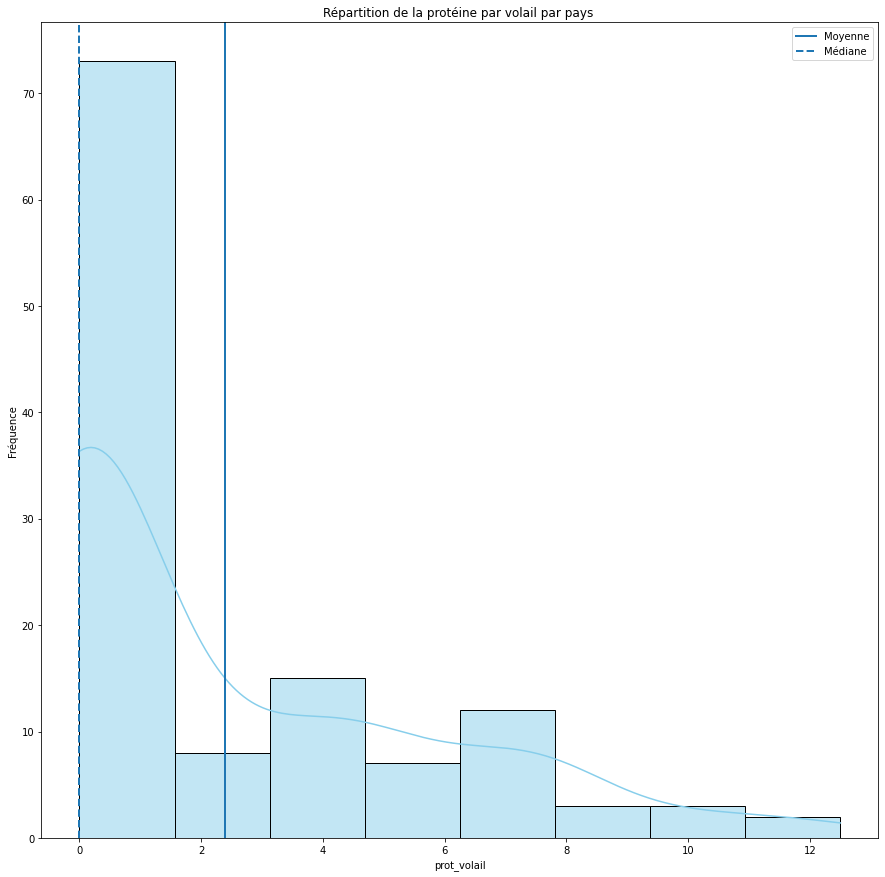

In [82]:
#Test de loi normal

plt.figure(figsize = (15,15))

sns.histplot(df6["prot_volail"],
                  kde=True,
                  color='skyblue',
                  )
plt.axvline(x=df6['prot_volail'].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df6['prot_volail'].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('prot_volail')
plt.ylabel('Fréquence')
plt.title('Répartition de la protéine par volail par pays ')
plt.legend()
plt.show()

In [83]:
ks_2samp(df6["prot_volail"],list(np.random.normal(np.mean(df6["prot_volail"]),np.std(df6["prot_volail"]), 1000)))

KstestResult(statistic=0.2770650406504065, pvalue=6.40041468713548e-08)

In [84]:
#Prot_Volail ne suit pas  la loi normal

# Kmeans

In [85]:
X=df6.values

In [86]:
inert=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    inert.append(kmeans.inertia_)

C:\Users\33753\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


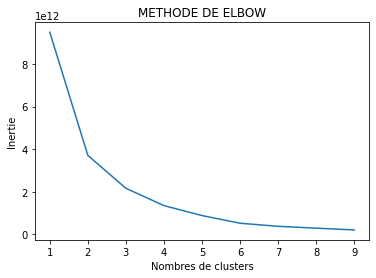

In [87]:
plt.plot(range(1,10),inert)
plt.title("METHODE DE ELBOW")
plt.xlabel("Nombres de clusters")
plt.ylabel("Inertie")
plt.show()

In [88]:
#Application de Kmeans 
kmeans=KMeans(n_clusters=4)
kmeans.fit(X)
clusters=kmeans.labels_

In [89]:
data_cluster = pd.DataFrame({'Zone' : df6.index.tolist(),
                             'kmeans_cluster' : clusters})
data_cluster = data_cluster.sort_values(['kmeans_cluster', 'Zone'])
data_cluster

,Zone,kmeans_cluster
2,Angola,0
3,Antigua-et-Barbuda,0
4,Bahamas,0
6,Bangladesh,0
10,Belize,0
...,...,...
79,Nouvelle-Zélande,3
111,Tunisie,3
112,Turquie,3
114,Ukraine,3


In [90]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 4
data_pca = df6[['dispo_kcal_hab_ans','dispo_prot_hab_ans','%prot_anim_prot_tot','pop_ratio','prot_volail',"PIB/habitant/US$"]]

X = df6.values
names = df6.index
features = df6.columns

In [91]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [92]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

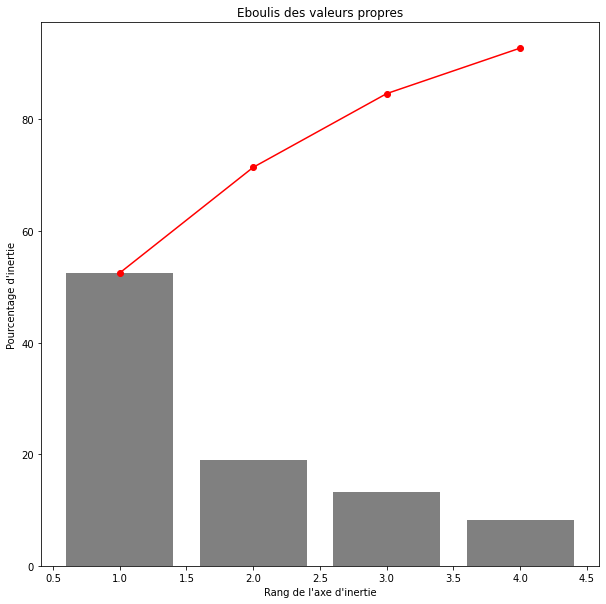

In [93]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

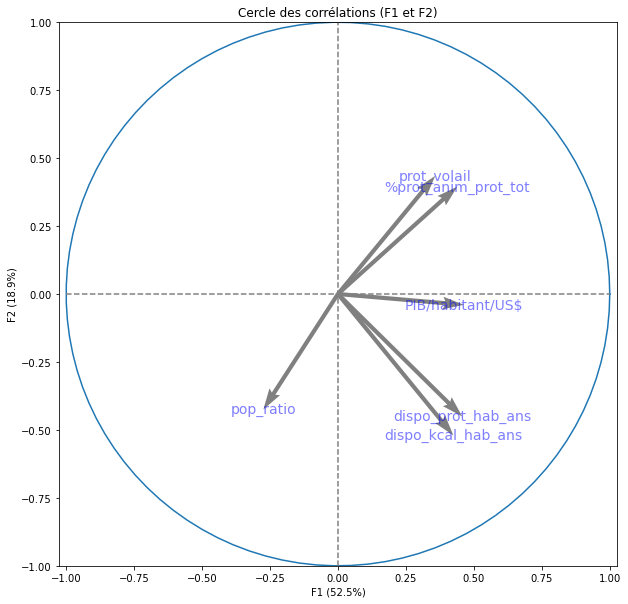

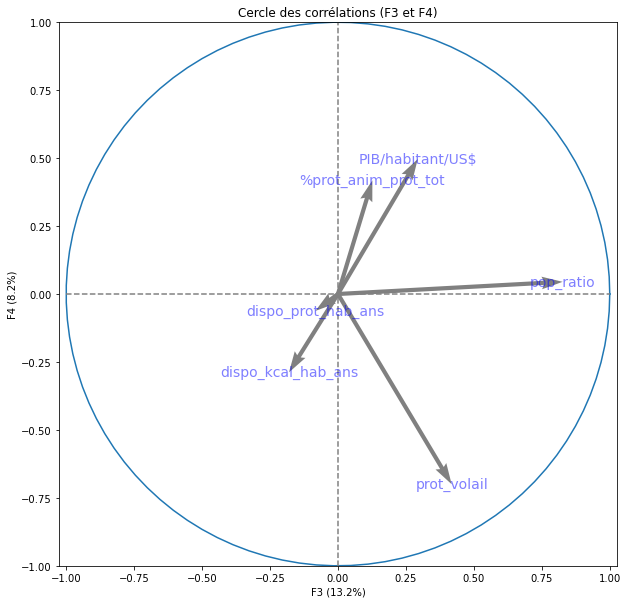

In [94]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))


In [95]:
df6=pd.merge(df6,data_cluster, on='Zone')
illustrative_var = df6['kmeans_cluster']
df6= df6.set_index('Zone')
df6.head()

,pop_ratio,PIB/habitant/US$,%prot_anim_prot_tot,dispo_prot_hab_ans,prot_volail,dispo_kcal_hab_ans,kmeans_cluster
Zone,,,,,,,
Afghanistan,3.124915,2102.4,20.83,42467.75,0.00,1529715.0,2
Algérie,2.066436,11512.7,29.24,69262.40,1.05,2463020.0,3
Angola,3.498663,8239.8,38.46,42277.95,4.32,1764045.0,0
Antigua-et-Barbuda,1.084678,18104.4,64.34,58294.15,10.64,1753095.0,0
Bahamas,0.964026,35659.9,67.70,61758.00,7.09,1925375.0,0


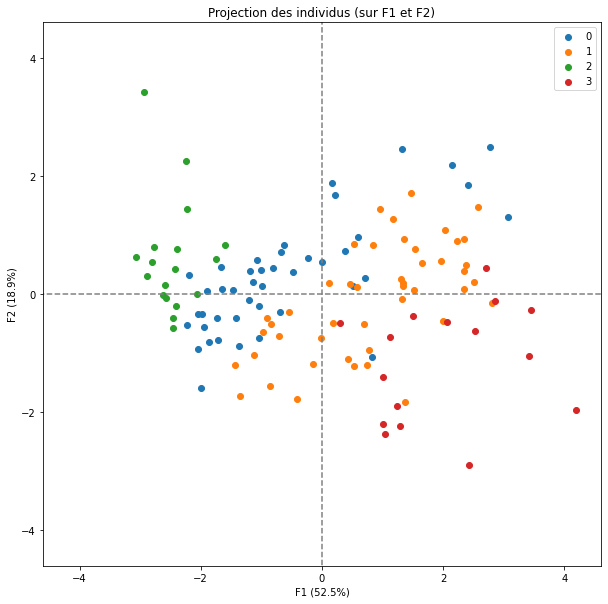

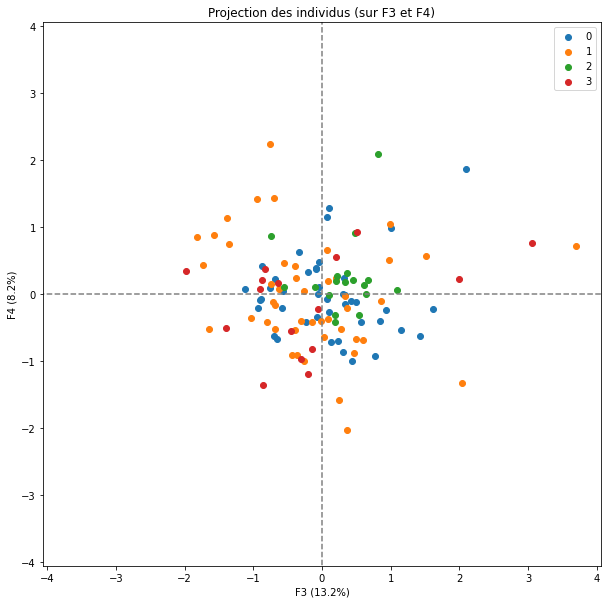

In [96]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var=illustrative_var)

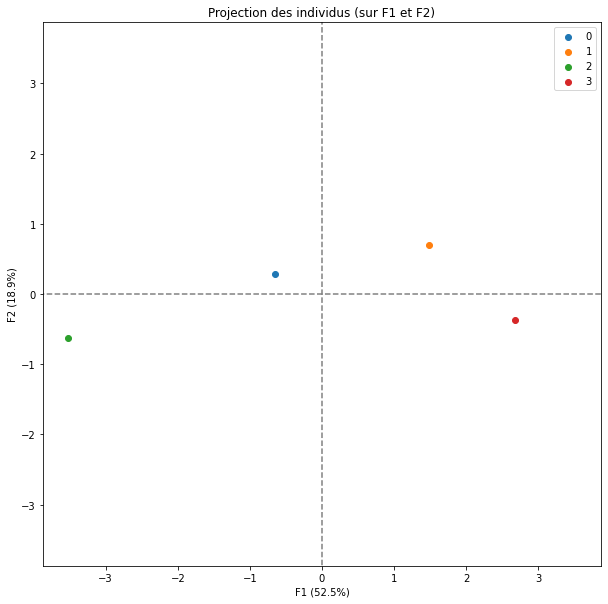

In [97]:
# Calculer la moyenne de chaque variable pour chaque cluster
df7 = pd.pivot_table(df6, columns='kmeans_cluster', aggfunc=np.mean).transpose()
df7 = df7[['pop_ratio','PIB/habitant/US$','%prot_anim_prot_tot','dispo_prot_hab_ans','prot_volail','dispo_kcal_hab_ans']]


X = df7.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df7.index)

In [98]:
df6['kmeans_cluster'].value_counts()

1    46
0    43
2    18
3    16
Name: kmeans_cluster, dtype: int64

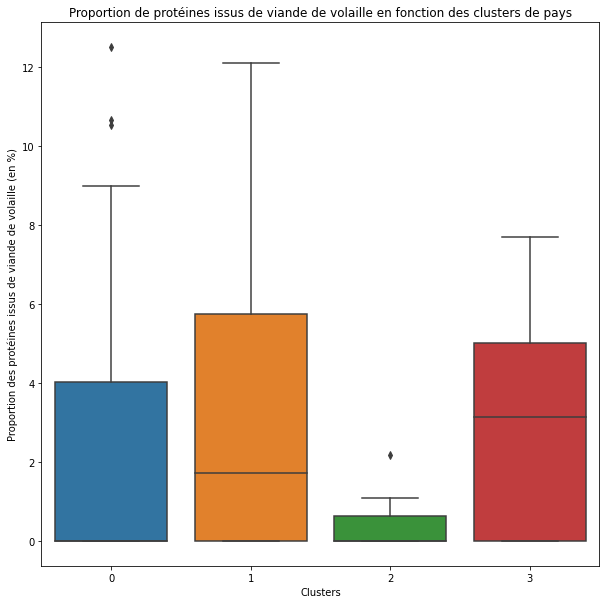

In [99]:
plt.figure(figsize=(10,10))

sns.boxplot(x='kmeans_cluster', y='prot_volail', data=df6)
plt.xlabel('Clusters')
plt.ylabel('Proportion des protéines issus de viande de volaille (en %)')
plt.title('Proportion de protéines issus de viande de volaille en fonction des clusters de pays')

plt.show()

In [100]:
clust1 = df6[df6["kmeans_cluster"]==1]["prot_volail"]
clust3 = df6[df6["kmeans_cluster"]==3]["prot_volail"]

# Réalisation d'un test de Mann-Whitney pour s'assurer de la significativité des différences
st.stats.mannwhitneyu(clust1, clust3)

MannwhitneyuResult(statistic=348.0, pvalue=0.3727765694535272)

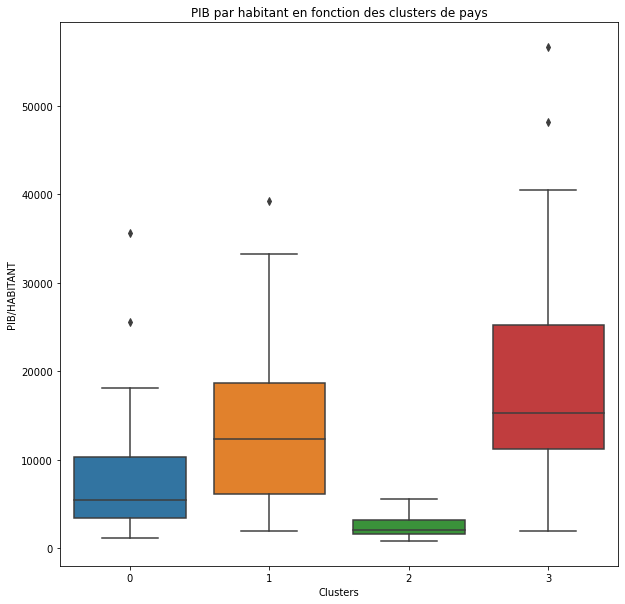

In [101]:
plt.figure(figsize=(10,10))

sns.boxplot(x='kmeans_cluster', y='PIB/habitant/US$', data=df6)
plt.xlabel('Clusters')
plt.ylabel('PIB/HABITANT')
plt.title('PIB par habitant en fonction des clusters de pays')



plt.show()

In [102]:
clust1 = df6[df6["kmeans_cluster"]==1]["PIB/habitant/US$"]
clust3 = df6[df6["kmeans_cluster"]==3]["PIB/habitant/US$"]

# Réalisation d'un test de Mann-Whitney pour s'assurer de la significativité des différences
st.stats.mannwhitneyu(clust1, clust3)

MannwhitneyuResult(statistic=273.0, pvalue=0.06422485261820332)

In [103]:
#Le résultat du test de Mann-Whitney montre une différence entre les deuxcluster
#Le PIB par habitant dans ces deux clusters sont  différents.

In [104]:
print(df6.loc[df6['kmeans_cluster'] ==3 ].index)

Index(['Algérie', 'Brésil', 'Azerbaïdjan', 'Égypte', 'Kiribati', 'Hongrie',
       'Iran (République islamique d')', 'Kazakhstan', 'Koweït', 'Mexique',
       'Maroc', 'Nouvelle-Zélande', 'Arabie saoudite', 'Tunisie', 'Turquie',
       'Ukraine'],
      dtype='object', name='Zone')


In [105]:
#Les pays du cluster 3 sont ceux ayant une croissance de population assez importante et un PIB par habitant moyen 

In [106]:
pays_choisi= df6.loc[(df6['kmeans_cluster']== 3)]
pays_choisi = pays_choisi.sort_values(['pop_ratio', 'PIB/habitant/US$'], ascending=False)
print(pays_choisi)

                                pop_ratio  PIB/habitant/US$  \
Zone                                                          
Koweït                           3.919055           56647.4   
Arabie saoudite                  2.591068           48209.1   
Égypte                           2.231572           10353.7   
Algérie                          2.066436           11512.7   
Turquie                          1.683498           24881.7   
Kazakhstan                       1.556996           24355.8   
Kiribati                         1.406880            1992.2   
Maroc                            1.378220            6912.2   
Iran (République islamique d')   1.325030           13038.6   
Mexique                          1.248912           18887.6   
Azerbaïdjan                      1.232145           14875.8   
Tunisie                          1.055282           10498.8   
Nouvelle-Zélande                 1.029113           40432.2   
Brésil                           0.842374           157